In [17]:
import os
import cv2
import time
import argparse
import multiprocessing
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
import sys
sys.path.append("..")
from object_detection.utils import ops as utils_ops

In [18]:
from utils import label_map_util
from utils import visualization_utils as vis_util

In [19]:
CWD_PATH = os.getcwd()

# Path to frozen detection graph. This is the actual model that is used for the object detection.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
PATH_TO_CKPT = os.path.join(CWD_PATH, MODEL_NAME, 'frozen_inference_graph.pb')

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join(CWD_PATH, 'data', 'mscoco_label_map.pbtxt')


In [20]:
NUM_CLASSES = 90

# Loading label map
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [21]:
def detect_objects(image_np, sess, detection_graph):
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')

    # Each box represents a part of the image where a particular object was detected.
    boxes = detection_graph.get_tensor_by_name('detection_boxes:0')

    # Each score represent how level of confidence for each of the objects.
    # Score is shown on the result image, together with the class label.
    scores = detection_graph.get_tensor_by_name('detection_scores:0')
    classes = detection_graph.get_tensor_by_name('detection_classes:0')
    num_detections = detection_graph.get_tensor_by_name('num_detections:0')

    # Actual detection.
    (boxes, scores, classes, num_detections) = sess.run(
        [boxes, scores, classes, num_detections],
        feed_dict={image_tensor: image_np_expanded})

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        np.squeeze(boxes),
        np.squeeze(classes).astype(np.int32),
        np.squeeze(scores),
        category_index,
        use_normalized_coordinates=True,
        line_thickness=8)
    return image_np

In [22]:
# First test on images
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 4) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [23]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

(1024, 636) (636, 1024, 3)
(2472, 1648) (1648, 2472, 3)
(2048, 1365) (1365, 2048, 3)


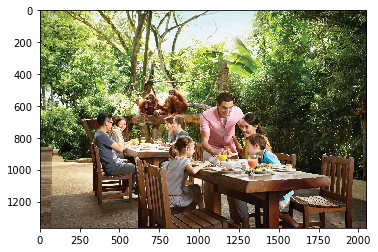

In [24]:
from PIL import Image
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)
    plt.imshow(image_np)
    print(image.size, image_np.shape)

In [25]:
#Load a frozen TF model 
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

(636, 1024, 3)
(1648, 2472, 3)
(1365, 2048, 3)


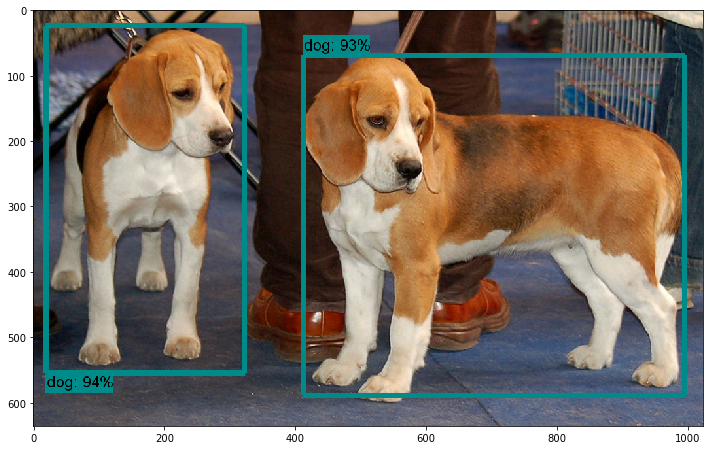

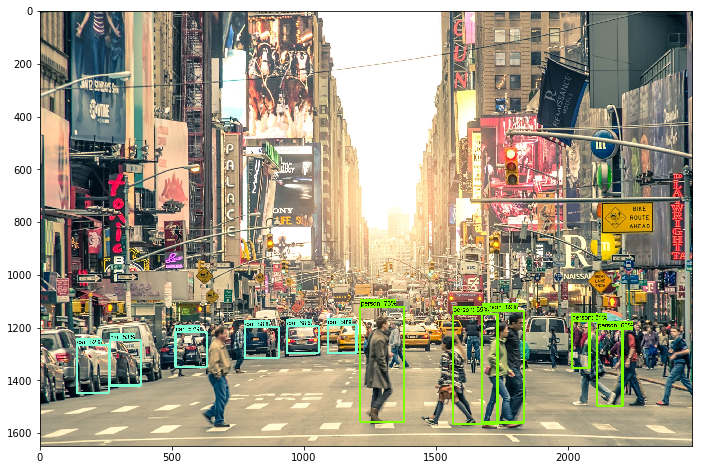

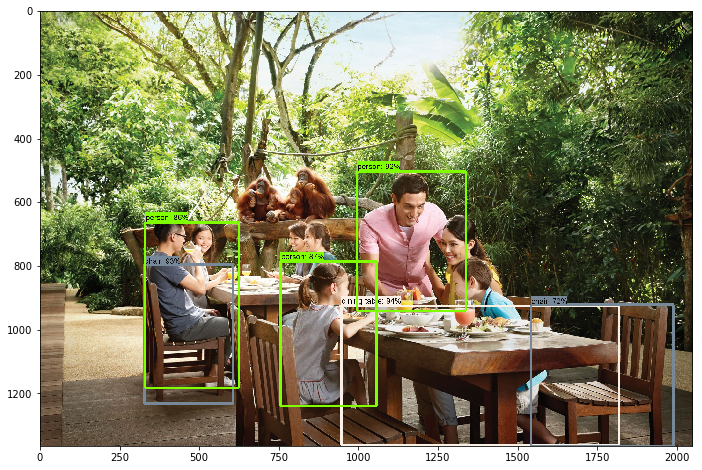

In [26]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        for image_path in TEST_IMAGE_PATHS:
            image = Image.open(image_path)
            image_np = load_image_into_numpy_array(image)
            image_process = detect_objects(image_np, sess, detection_graph)
            print(image_process.shape)
            plt.figure(figsize=IMAGE_SIZE)
            plt.imshow(image_process)
      

In [44]:
!pip install moviepy

  Running setup.py bdist_wheel for moviepy: started
  Running setup.py bdist_wheel for moviepy: finished with status 'done'
  Stored in directory: C:\Users\User\AppData\Local\pip\Cache\wheels\10\72\35\0ae7f2cd32164a4c8c7bb613d1fe7cf0c957d96bc63ba52972
Successfully built moviepy


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [47]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [48]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image with lines are drawn on lanes)
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            image_process = detect_objects(image, sess, detection_graph)
            return image_process

In [49]:
white_output = 'video1_out.mp4'
clip1 = VideoFileClip("video1.mp4").subclip(0,2)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video video1_out.mp4
[MoviePy] Writing video video1_out.mp4


 98%|████████████████████████████████████████████████████████████████████████████████▍ | 50/51 [01:37<00:01,  1.94s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video1_out.mp4 

Wall time: 1min 37s


In [50]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [52]:
white_output1 = 'beach_out.mp4'
clip1 = VideoFileClip("beach.mp4").subclip(10,20)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output1, audio=False)

[MoviePy] >>>> Building video beach_out.mp4
[MoviePy] Writing video beach_out.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 250/251 [08:10<00:01,  1.96s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: beach_out.mp4 

Wall time: 8min 10s


In [53]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output1))

In [17]:
white_output2 = 'fruits1_out.mp4'
clip2 = VideoFileClip("fruits1.mp4").subclip(0,1)
white_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output2, audio=False)

[MoviePy] >>>> Building video fruits1_out.mp4
[MoviePy] Writing video fruits1_out.mp4


100%|██████████| 30/30 [00:21<00:00,  1.42it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: fruits1_out.mp4 

CPU times: user 41.9 s, sys: 1.65 s, total: 43.6 s
Wall time: 21.3 s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output2))

In [40]:
white_output3 = 'dog_out.mp4'
clip3 = VideoFileClip("dog.mp4").subclip(12,14)
white_clip = clip3.fl_image(process_image) #NOTE: this function expects color images!!s
%time white_clip.write_videofile(white_output3, audio=False)

[MoviePy] >>>> Building video dog_out.mp4
[MoviePy] Writing video dog_out.mp4


100%|██████████| 60/60 [00:43<00:00,  1.43it/s]

[MoviePy] Done.
[MoviePy] >>>> Video ready: dog_out.mp4 

CPU times: user 1min 25s, sys: 3.58 s, total: 1min 29s
Wall time: 43.7 s


In [41]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output3))

In [42]:
# Merge videos
from moviepy.editor import VideoFileClip, concatenate_videoclips
clip1 = VideoFileClip("cars_out.mp4")
clip2 = VideoFileClip("fruits1_out.mp4")
clip3 = VideoFileClip("dog_out.mp4")
final_clip = concatenate_videoclips([clip1,clip2,clip3], method="compose")
final_clip.write_videofile("my_concatenation.mp4",bitrate="5000k")

[MoviePy] >>>> Building video my_concatenation.mp4
[MoviePy] Writing video my_concatenation.mp4


100%|██████████| 150/150 [00:00<00:00, 189.12it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: my_concatenation.mp4 



In [43]:
from moviepy.editor import *
clip = VideoFileClip("my_concatenation.mp4")
clip.write_gif("final.gif")


[MoviePy] Building file final.gif with imageio


100%|██████████| 151/151 [00:11<00:00, 12.35it/s]
